In [37]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt
import open3d as o3d
from PIL import Image

## Meshes

In [38]:
obj_path = "../no_git_test_data/88-1/model_cleaned.obj"

tm_test = trimesh.load(obj_path)

In [39]:
tm_test.visual.material.to_color([[0, 0]])

array([[0, 0, 0, 0]], dtype=uint8)

In [40]:
# dir = *(...row1), *(...row2), ... 
grid = (np.indices((512, 512)).swapaxes(0, 2).reshape((-1, 2)) - 256) 
directions = np.concatenate([grid / 256 / np.sqrt(3), np.ones((grid.shape[0], 1))*-1], axis=1)
origins = np.zeros(directions.shape)
origins[:, -1] = 1

result = tm_test.ray.intersects_id(origins, directions, multiple_hits=True, max_hits=4, return_locations=True)

In [41]:
directions

array([[-0.57735027, -0.57735027, -1.        ],
       [-0.57509499, -0.57735027, -1.        ],
       [-0.57283972, -0.57735027, -1.        ],
       ...,
       [ 0.57058445,  0.57509499, -1.        ],
       [ 0.57283972,  0.57509499, -1.        ],
       [ 0.57509499,  0.57509499, -1.        ]])

In [42]:
result[0]

array([42360, 11824, 33322, ..., 14573, 41423, 13359], dtype=int64)

In [43]:
# sort intersection by depth
import pandas as pd

face_ids, ray_ids, locations = result
argsort = np.argsort(locations[:, -1])[::-1]
face_ids = face_ids[argsort]
locations = locations[argsort]
ray_ids = ray_ids[argsort]

counts = pd.Series(ray_ids)
counts = counts.groupby(counts).cumcount().to_numpy()

# i = layer; peelmaps[i] = (world_coords, pixel_coords)
peelmaps = [(locations[counts == i], ray_ids[counts == i], face_ids[counts == i]) for i in range(4)]

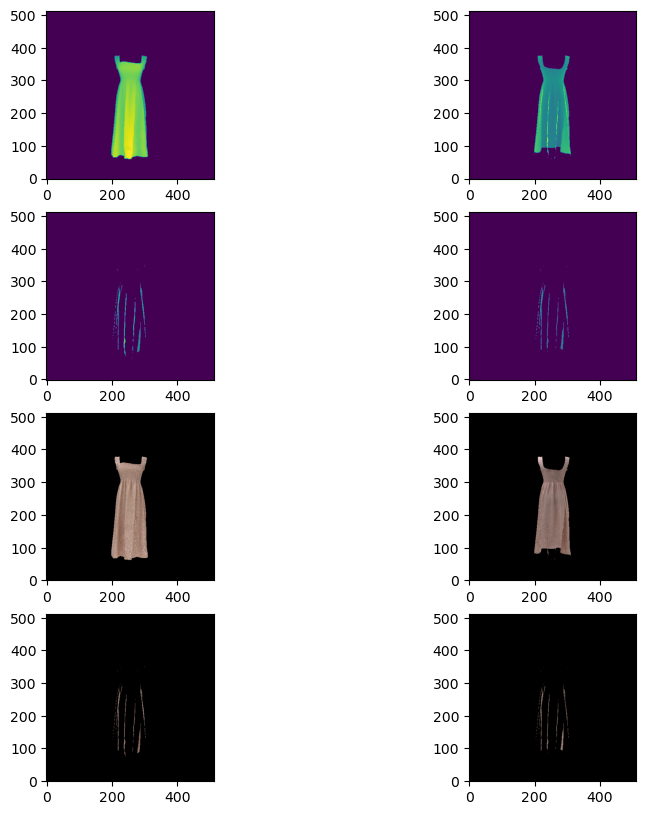

In [57]:
pm_depth = []
pm_rgba = []
pm_normals = []

fig, ax = plt.subplots(4, 2, figsize=(10, 10))
normal_lines = []

for i, (world_coords, pixel_coords, face_ids) in enumerate(peelmaps):
    row = pixel_coords // 512
    col = pixel_coords % 512

    """
    depth
    """
    depth = np.zeros((512, 512))
    depth[row, col] = world_coords[:, -1]
    pm_depth.append(depth)
    
    # save depth
    with open(f"../no_git_test_data/pcd/peelmap_depth_{i}.npy", "wb") as f:
        np.save(f, depth)

    """
    rgba
    """
    faces = tm_test.faces[face_ids]     # indices of the 3 vertices of the face
    uv = tm_test.visual.uv[faces]       # 2d image coordinates of the 3 vertices
    bary = trimesh.triangles.points_to_barycentric(tm_test.vertices[faces], world_coords)
    uv_hit = bary.reshape(-1, 1, 3) @ uv
    rgba = tm_test.visual.material.to_color(uv_hit.reshape(-1, 2))
    rgba_img = np.zeros((512, 512, 4), dtype=np.uint8)
    rgba_img[row, col] = rgba.astype(np.uint8)

    rgb_img = Image.fromarray(rgba_img)
    rgb_img = rgb_img.convert("RGB")
    
    pm_rgba.append(np.array(rgb_img))

    # save rgba
    with open(f"../no_git_test_data/pcd/peelmap_rgba_{i}.npy", "wb") as f:
        np.save(f, rgba_img)

    """
    normal
    """
    normals = tm_test.face_normals[face_ids]
    pm_normals.append(normals)

    # save normals
    with open(f"../no_git_test_data/pcd/peelmap_normals_{i}.npy", "wb") as f:
        np.save(f, normals)

    """
    display
    """
    # for display, rescale the depth between 0.3 - 0.8
    tmp = depth[row, col]
    tmp = np.interp(tmp, (tmp.min(), tmp.max()), (0.3, 0.8))
    depth_img = np.zeros_like(depth)
    depth_img[row, col] = tmp
    ax[i//2, i%2].imshow(depth_img, origin="lower")

    # rgba
    ax[2 + i//2, i%2].imshow(np.array(rgb_img), origin="lower")

    # normals
    line_norm = np.hstack([normals, normals + (normals * 0.05)])
    normal_lines.append(line_norm)
    
    # save pcd
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(world_coords)
    # pcd.colors = o3d.utility.Vector3dVector(rgb)
    o3d.io.write_point_cloud(f"../no_git_test_data/pcd/peelmap_{i}.ply", pcd)

In [19]:
pm_depth[0][pm_depth[0] > 0.01].shape

(26370,)

In [8]:
def sort_by_z(arr):
    args = np.argsort(arr[:, -1])
    return arr[args]

In [13]:
import copy

def create_idx_mat(size):
    return np.indices(size).swapaxes(0, 2).reshape((-1, 2))

def create_norm_coords(size, idx_mat=None):
    assert size[0] % 2 == 0 and size[1] % 2 == 0
    if idx_mat is None:
        idx_mat = create_idx_mat(size)
    else:
        idx_mat = copy.deepcopy(idx_mat)

    idx_mat[:, 0] -= size[0] // 2
    idx_mat[:, 1] -= size[1] // 2
    # idx_mat[:, 1] *= -1
    return idx_mat

def transform_coords_norm2real(size, coords, z, fov):
    """
    transform pixel coordinates `[[-pix_x/2, -pix_y/2], ..., [0, 0], ..., [pix_x/2, pix_y/2]]` to 3d world (x, y) coordinates.
    """
    real_coords = np.zeros_like(coords, dtype=np.float64)
    def __compute_pixsep(__s, __fov):
        """
        compute real distance between each pixel.
        """
        a = z*np.tan(__fov / 2)
        return __s / a / 2

    if type(fov) == tuple:
        assert len(size) == len(fov)
        sep = [__compute_pixsep(s, f) for s, f in zip(size, fov)]
    else:
        sep = __compute_pixsep(size[0], fov)
        sep = [sep for _ in range(len(size))]

    for dim in range(len(coords.shape)):
        real_coords[:, dim] = coords[:, dim] / sep[dim]

    return real_coords, sep

# reconstruct from depth
def reconstruct_from_depth(img_size, pm_depth, z, fov):
    pcd = []
    pix_coords = create_idx_mat(img_size)
    row, col = pix_coords[:, 1], pix_coords[:, 0]
    
    pix_coords_norm = create_norm_coords(img_size, idx_mat=pix_coords)
    real_coords, sep = transform_coords_norm2real(img_size, pix_coords_norm, z, fov)
    
    for depth in pm_depth:
        # flatten depth peelmaps
        f_d = depth[row, col].reshape(-1, 1)
        # reconstruct original (x, y) coordinates
        p = real_coords * (1 - f_d/z)
        p = np.hstack([p, f_d])[(f_d != 0).flatten()]
        pcd.append(p)

    return np.vstack(pcd)

pcd = reconstruct_from_depth((512, 512), pm_depth, 1, np.pi/3)
pcd = pcd[pcd[:, -1] != 0]

pcd = np.vstack(pcd)
reconstructed = o3d.geometry.PointCloud()
reconstructed.points = o3d.utility.Vector3dVector(pcd)
o3d.io.write_point_cloud(f"../no_git_test_data/pcd/reconstructed.ply", reconstructed)

True

## texture

In [17]:
np.sort(peelmaps[0][0][:, -1])

array([-0.04770607, -0.04672332, -0.04565222, ...,  0.13657716,
        0.13665532,  0.13669442])

In [17]:
create_idx_mat((512, 512))

array([[  0,   0],
       [  1,   0],
       [  2,   0],
       ...,
       [509, 511],
       [510, 511],
       [511, 511]])

In [16]:
pm_depth[0][256, 256]

0.08489826573813364

In [13]:
directions

array([[-0.57735027, -0.57735027, -1.        ],
       [-0.57509499, -0.57735027, -1.        ],
       [-0.57283972, -0.57735027, -1.        ],
       ...,
       [ 0.57058445,  0.57509499, -1.        ],
       [ 0.57283972,  0.57509499, -1.        ],
       [ 0.57509499,  0.57509499, -1.        ]])

In [ ]:
pcd[0]

array([-0.52833423, -0.52833423,  0.08489827])

In [ ]:
np.tan(np.pi/6)

0.5773502691896257

In [ ]:
peelmaps[0][0][peelmaps[0][0][:, -1] - 0.08489827 < 1e-9]

array([[ 0.        ,  0.        ,  0.08489827],
       [ 0.0804887 , -0.26623185,  0.08489508],
       [-0.01444671,  0.07016976,  0.08489349],
       ...,
       [-0.07546345,  0.25233091, -0.04565222],
       [-0.07554075,  0.25022873, -0.04672332],
       [-0.07561167,  0.2481008 , -0.04770607]])

In [ ]:
ref = peelmaps[0][0][:, -1]
ref

array([ 0.13669442,  0.13665532,  0.13657716, ..., -0.04565222,
       -0.04672332, -0.04770607])

In [ ]:
tmp = pm_depth[0].reshape(-1, 1)
tmp = sort_by_z(tmp[tmp != 0].reshape(-1, 1))

np.count_nonzero(~(tmp.flatten() == ref))

0

In [ ]:
sort_by_z(pcd)

TypeError: 'open3d.cpu.pybind.geometry.PointCloud' object is not subscriptable

In [ ]:
np.unique(pcd)

array([0.])

In [ ]:
# import open3d as o3d

# eagle = o3d.data.EaglePointCloud()
# pcd = o3d.io.read_point_cloud(eagle.path)

# o3d.visualization.draw_geometries([pcd],
#                                   zoom=0.664,
#                                   front=[-0.4761, -0.4698, -0.7434],
#                                   lookat=[1.8900, 3.2596, 0.9284],
#                                   up=[0.2304, -0.8825, 0.4101])


# print('run Poisson surface reconstruction')
# with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
#     mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)
# print(mesh)
# o3d.visualization.draw_geometries([mesh],
#                                   zoom=0.664,
#                                   front=[-0.4761, -0.4698, -0.7434],
#                                   lookat=[1.8900, 3.2596, 0.9284],
#                                   up=[0.2304, -0.8825, 0.4101])


# Render

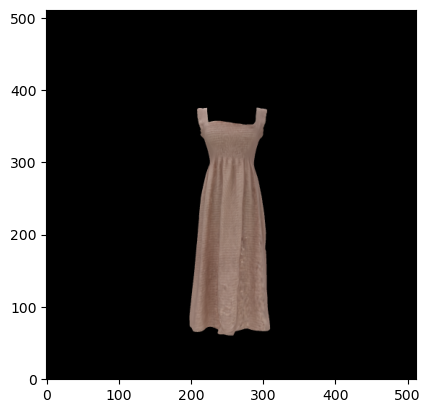

In [55]:
import pyrender

pr_mesh = pyrender.Mesh.from_trimesh(tm_test)
scene = pyrender.Scene(ambient_light=[1., 1., 1.], bg_color=[0, 0, 0])
scene.add(pr_mesh)
camera = pyrender.PerspectiveCamera(yfov=np.pi/3, aspectRatio=1)
camera_pose = np.array([
    [1, 0, 0, 0],
    [0 ,1, 0, 0],
    [0, 0, 1, 1],
    [0, 0, 0, 1]
])
scene.add(camera, pose=camera_pose)
r = pyrender.OffscreenRenderer(512, 512)
c, d = r.render(scene)
plt.imshow(c[::-1], origin="lower")

In [50]:
c.shape

(512, 512, 3)